In [1]:
import numpy as np
import cte
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
from ProcessFunctions import Find_T_X_tau_without_p_input


# To do:
* Find the event timing for QDYN, model N_m=20, and model N_m=30. As a check point, time of the event should give you zero for the PDE.

This code is written to plot the prediction using the PDE as governing equation and estimated initial condition using data assimilation with ROM.
To generate data for this code, you need to run `Fig_Stress_Vel_inversion.ipynb`


In [2]:
Tf = 250 # each initial condition is simulated for 250 years
Nt=5     # it is recorded every Nt time stes
N_m_load=30
coeff=2 # How the inital conditions are from the chaotic attractor
Obs_linear=0
N_t=4000
m=80
sigma_kernel=2000
gamma_ratio=0.0001*5
version=2024.11
Mag_thresh=6.9
tau=0.1
L=cte.L_asp+cte.L_buffer  
Nx=256
T_final=5*tau*cte.t_yr # plotting 30 tau of simulation
V_thresh=(5e-8) # to define an event
L_thresh=1e3 # to define an event
t_yr=cte.t_yr
size_x=256
size_y=32
W=cte.W  
x_ox=np.linspace(-L/2,L/2,size_x)
z_ox=np.linspace(0,W,size_y)
L_fault=L
mu=30e9


In [3]:
# for different inversions (denoted by number) and differnet ROM (denoted by N_m_v), we need to load the corresponding data
N_m_v_list = [20,30]
#numbers = [101,102]
numbers = [102]
data_PDE = []
data_prediction_20 = []
data_prediction_30 = []
data_inversion_20 = []
data_inversion_30 = []
for i in range(len(numbers)):
    number=numbers[i]
    data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/Dataset2/SampleSimulation_Tf"+str(Tf)+"Nt="+str(Nt)+"N_m"+str(N_m_load)+"coeff"+str(coeff)+"number"+str(number)+".npz"
    data=np.load(data_dir)
    data_PDE.append(data)
    for j in range(len(N_m_v_list)):

        N_m_v=N_m_v_list[j]
        N_m_theta=N_m_v
        data_dir_pred="/central/groups/astuart/hkaveh/Data/LearnROM/PredictionN_m_v"+str(N_m_v)+"N_m_theta"+str(N_m_theta)+"Obs_linear"+str(Obs_linear)+"N_t"+str(N_t)+"m"+str(m)+"sigma_kernel"+str(sigma_kernel)+"gamma_ratio"+str(gamma_ratio)+"version"+str(version)+"NumberinDataset"+str(number)+"tau"+str(tau)+"Mag_thresh"+str(Mag_thresh)+".npz"
        data=np.load(data_dir_pred,allow_pickle=True)
        if N_m_v==20:
            data_inversion=np.load("/central/groups/astuart/hkaveh/Data/LearnROM/EnKF_N_m_v"+str(N_m_v)+"N_m_theta"+str(N_m_theta)+"Obs_linear"+str(Obs_linear)+"N_t"+str(N_t)+"m"+str(m)+"sigma_kernel"+str(sigma_kernel)+"gamma_ratio"+str(gamma_ratio)+"version"+str(version)+"NumberinDataset"+str(number)+'.npz')
            data_inversion_20.append(data_inversion)
            data_prediction_20.append(data)
        elif N_m_v==30:
            data_inversion=np.load("/central/groups/astuart/hkaveh/Data/LearnROM/EnKF_N_m_v"+str(N_m_v)+"N_m_theta"+str(N_m_theta)+"Obs_linear"+str(Obs_linear)+"N_t"+str(N_t)+"m"+str(m)+"sigma_kernel"+str(sigma_kernel)+"gamma_ratio"+str(gamma_ratio)+"version"+str(version)+"NumberinDataset"+str(number)+'.npz')
            data_inversion_30.append(data_inversion)
            data_prediction_30.append(data)
    

In [4]:
# The inversion data is saved like : np.savez('/central/groups/astuart/hkaveh/Data/LearnROM/Prediction'+"N_m_v"+str(N_m_v)+"N_m_theta"+str(N_m_theta)+"Obs_linear"+str(Obs_linear)+"N_t"+str(N_t)+"m"+str(m)+"sigma_kernel"+str(sigma_kernel)+"gamma_ratio"+str(gamma_ratio)+"version"+str(version)+"NumberinDataset"+str(number)+"tau"+str(tau)+"Mag_thresh"+str(Mag_thresh)+".npz",V_ox_pred_events=V_ox_pred_events,t_ox_pred_events=t_ox_pred_events,TimeStarts_preds_events=TimeStarts_preds_events,Mags_preds_events=Mags_preds_events,index_events=index_events,TimeStarts_filtered=TimeStarts_filtered,TimeEnds_filtered=TimeEnds_filtered,rectangles_filtered=rectangles_filtered,Mags_filtered=Mags_filtered)


In [5]:
# finding total number of events=nroww: pick one N_m_v. for all of the inversions sum the number of elements in Mags_filtered
# writing this in one line
nrows=sum([data_prediction_20[i]['Mags_filtered'].shape[0] for i in range(len(data_prediction_20))])

In [6]:
letters=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

In [7]:
def interpolate(time_interpolation,original_time,original_data,size_y,size_x):
    output=np.zeros((len(time_interpolation),size_y,size_x))
    for i in range(size_y):
        for j in range(size_x):
            f = interp1d(original_time[:,i,j], original_data[:,i,j], kind='linear')
            output[:,i,j]=f(time_interpolation)
    return output

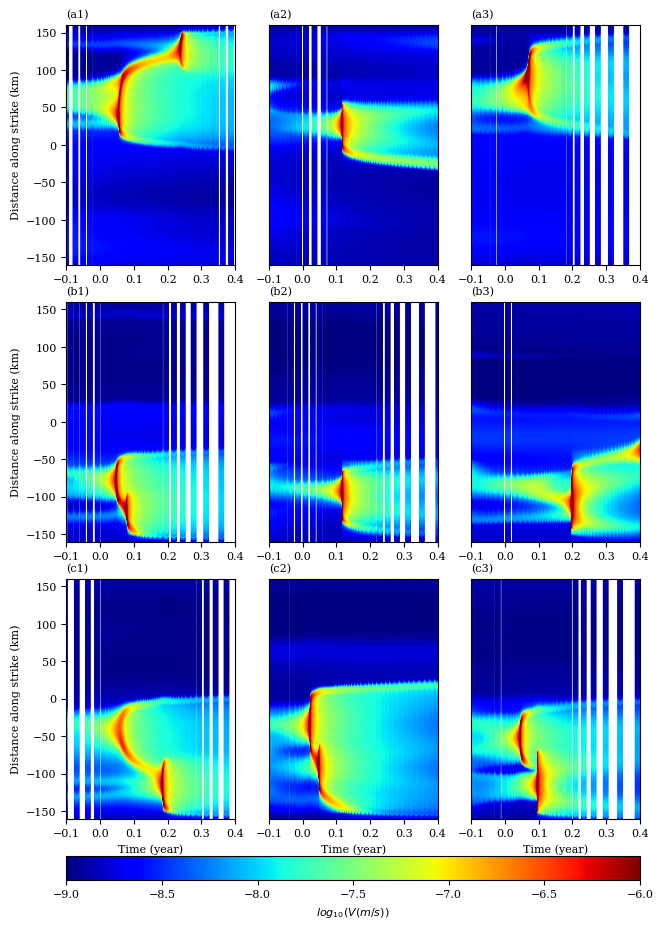

In [8]:
# making a nice plot for the paper

# I am thinking of of 3 collomn figure with the first coloumn to be the QDYN simulation, the second one with N_m=20 and the third one to be N_m=30. 
# This should be a good idea that you can also see the difference in the forecast as well.
# this block is plotted without interpolation so you can see some white shades. 
# In the next block I interpolate things, so there is no white shade.
# To make this plot, I think it is better that you have already saved everything in the variables.
V_thresh_min=1e-9
V_thresh_max=1e-6  
x_ox=np.linspace(-L/2,L/2,Nx) 
# 1- define the figure size and the font size
fig = plt.figure(figsize=(7.4, nrows*3.7))
serif_font = fm.FontProperties(family="serif", size=8)
cmap='jet'
    # Use serif font and set font size for all text in the figure
plt.rc('font', family='serif')
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 8})
height_ratios=([1]*nrows)
height_ratios.append(0.1)
gs = gridspec.GridSpec(nrows=nrows+1, ncols=3,width_ratios=[1,1,1],height_ratios=height_ratios) # I put 2 columns for now to wait to see how does the system look like for N_m=30
index_row_plot=0
cax=fig.add_subplot(gs[-1, :])  
shift_string=10
for index in range(len(numbers)):
#for index in range(1): # for example when index=0 number =101
    time_start_events_PDE=data_prediction_20[index]['TimeStarts_filtered']
    t_0_inversion=data_inversion_20[index]['t_0']
    V_ox_pred_events_20=data_prediction_20[index]["V_ox_pred_events"]
    V_ox_pred_events_30=data_prediction_30[index]["V_ox_pred_events"]
    t_ox_pred_events_20=data_prediction_20[index]["t_ox_pred_events"]
    t_ox_pred_events_30=data_prediction_30[index]["t_ox_pred_events"]
    # run the code to plot things
    for event_counter in range(data_prediction_20[index]['Mags_filtered'].shape[0]): # number of events in the indexth number
        ax_qdyn= fig.add_subplot(gs[index_row_plot, 0]) # True slip rate
        ax_Nm20= fig.add_subplot(gs[index_row_plot, 1]) # Observed slip rate
        ax_Nm30= fig.add_subplot(gs[index_row_plot, 2]) # Observed slip rate
        string_qdyn='('+letters[index_row_plot]+'1)'
        string_20='('+letters[index_row_plot]+'2)'
        string_30='('+letters[index_row_plot]+'3)'
        # cax1 = fig.add_subplot(gs[index_row_plot, 1])  
        # cax2 = fig.add_subplot(gs[index_row_plot, 3]) 
        # cax3 = fig.add_subplot(gs[index_row_plot, 5])
        # loading data in data_PDE[index]
        V_ox=data_PDE[index]['array1']
        theta_ox=data_PDE[index]['array2']
        t_ox=data_PDE[index]['array3']
        # loading time of the start of the events: TimeStarts_filtered, this number should be added to start time which is the time that inversion starts


        # Plotting the QDYN acutual slip profile for the events
        V_dip_mean=np.max(V_ox,axis=1).T   # Mean Velocity along the dip
        Nt=t_ox.shape[0]
        x_ox_t=np.vstack([x_ox]*Nt).T 
        time=np.max(t_ox,axis=1).T 
        PrettyTime=np.reshape(time.T,-1)
        Prettyx=np.reshape(x_ox_t.T,-1)
        PrettyV=np.reshape(V_dip_mean.T,-1)
        xlimleft=((time_start_events_PDE[event_counter]+t_0_inversion)/cte.t_yr)
        xlimright=((time_start_events_PDE[event_counter]+t_0_inversion)/cte.t_yr)+(T_final/cte.t_yr)
        
        pl=ax_qdyn.scatter(PrettyTime/cte.t_yr-xlimleft,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1,vmin=np.log10(V_thresh_min),vmax=np.log10(V_thresh_max))  
        ax_qdyn.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)

        ax_qdyn.set_xlim(left=-tau,right=-tau+(T_final/cte.t_yr))
        # b=fig.colorbar(pl,cax=cax1)
        # b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
        ax_qdyn.set_ylim(bottom=-L/2/1e3,top=L/2/1e3)
        index_row_plot+=1
        ax_qdyn.text(-tau,L/2/1000+shift_string,string_qdyn)

        # plotting N_m_v=20
        V_dip_mean=np.max(V_ox_pred_events_20[event_counter],axis=1).T   # Mean Velocity along the dip
        Nt=t_ox_pred_events_20[event_counter].shape[0]
        x_ox_t=np.vstack([x_ox]*Nt).T 
        x_ox_t=np.vstack([x_ox]*Nt).T 
        time=np.max(t_ox_pred_events_20[event_counter],axis=1).T # what? simply getting rid of the axis 1 because axis 0 and 1 have the same value for time
        
        PrettyTime=np.reshape(time.T,-1)
        Prettyx=np.reshape(x_ox_t.T,-1)
        PrettyV=np.reshape(V_dip_mean.T,-1)
        pl=ax_Nm20.scatter(PrettyTime/cte.t_yr-tau,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1,vmin=np.log10(V_thresh_min),vmax=np.log10(V_thresh_max))
        ax_Nm20.set_xlim(left=-tau,right=-tau+T_final/cte.t_yr)

        # ax_Nm20.set_xlabel(r'Time (year)',fontproperties=serif_font)
        # ax_Nm20.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
        # b=fig.colorbar(pl,cax=cax2)
        # b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
        ax_Nm20.set_ylim(bottom=-L/2/1e3,top=L/2/1e3)
        ax_Nm20.text(-tau,L/2/1000+shift_string,string_20)

        # plotting N_m_v=30
        V_dip_mean=np.max(V_ox_pred_events_30[event_counter],axis=1).T   # Mean Velocity along the dip
        Nt=t_ox_pred_events_30[event_counter].shape[0]
        x_ox_t=np.vstack([x_ox]*Nt).T
        time=np.max(t_ox_pred_events_30[event_counter],axis=1).T 
        PrettyTime=np.reshape(time.T,-1)
        Prettyx=np.reshape(x_ox_t.T,-1)
        PrettyV=np.reshape(V_dip_mean.T,-1)
        pl=ax_Nm30.scatter(PrettyTime/cte.t_yr-tau,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1,vmin=np.log10(V_thresh_min),vmax=np.log10(V_thresh_max))
        ax_Nm30.set_xlim(left=-tau,right=-tau+T_final/cte.t_yr)
        # ax_Nm30.set_xlabel(r'Time (year)',fontproperties=serif_font)
        # ax_Nm30.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
        # b=fig.colorbar(pl,cax=cax3)
        # b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
        ax_Nm30.set_ylim(bottom=-L/2/1e3,top=L/2/1e3)
        ax_Nm30.text(-tau,L/2/1000+shift_string,string_30)
        # removing y ticks and y numbers 
        #ax_qdyn.set_yticks([])
        ax_Nm20.set_yticks([])
        ax_Nm30.set_yticks([])
        
    
    # putting the xlable outside both of the loops to only print the lable for the last row
ax_qdyn.set_xlabel(r'Time (year)',fontproperties=serif_font)
ax_Nm20.set_xlabel(r'Time (year)',fontproperties=serif_font)
ax_Nm30.set_xlabel(r'Time (year)',fontproperties=serif_font)
b=fig.colorbar(pl,cax=cax,orientation='horizontal')
b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)

    
    
plt.show()


In [9]:
N_time=int(T_final/(2*3600))
time_interpolation=np.linspace(0,T_final,N_time)


In [10]:
1*365*24*3600/4000

7884.0

In [11]:
# Expand the dimensions of 'a' to make it (1000, 1, 1)
t_expanded = time_interpolation[:, np.newaxis, np.newaxis]

# Use np.tile to copy the values along the other dimensions
t_expanded = np.tile(t_expanded, (1, 32, 256))


[0.00114155]
[0.00525114]
[0.01255708]


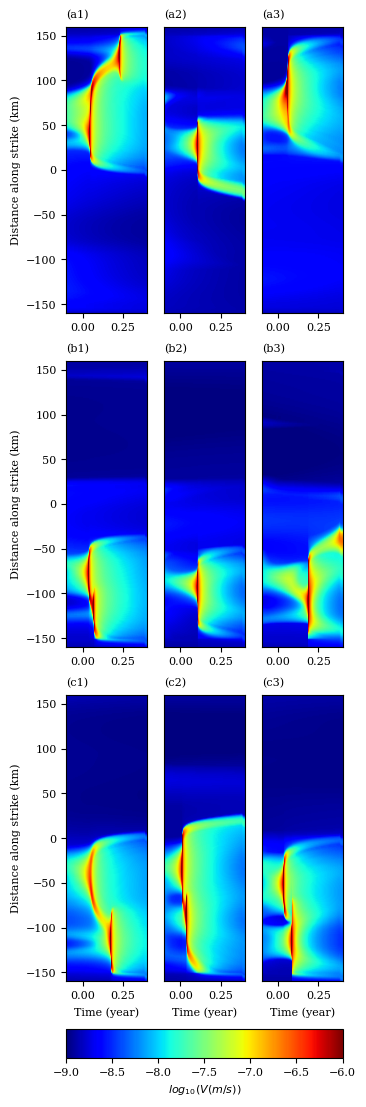

In [12]:
# making a nice plot for the paper
# I am thinking of of 3 collomn figure with the first coloumn to be the QDYN simulation, the second one with N_m=20 and the third one to be N_m=30. 
# This should be a good idea that you can also see the difference in the forecast as well.

# To make this plot, I think it is better that you have already saved everything in the variables.
V_thresh_min=1e-9
V_thresh_max=1e-6  
x_ox=np.linspace(-L/2,L/2,Nx) 
# 1- define the figure size and the font size
fig = plt.figure(figsize=(3.7, nrows*3.7))
serif_font = fm.FontProperties(family="serif", size=8)
cmap='jet'
    # Use serif font and set font size for all text in the figure
plt.rc('font', family='serif')
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 8})
height_ratios=([1]*nrows)
height_ratios.append(0.1)
gs = gridspec.GridSpec(nrows=nrows+1, ncols=3,width_ratios=[1,1,1],height_ratios=height_ratios) # I put 2 columns for now to wait to see how does the system look like for N_m=30
index_row_plot=0
cax=fig.add_subplot(gs[-1, :])  
shift_string=10
for index in range(len(numbers)):
    time_start_events_PDE=data_prediction_20[index]['TimeStarts_filtered']
    t_0_inversion=data_inversion_20[index]['t_0']
    V_ox_pred_events_20=data_prediction_20[index]["V_ox_pred_events"]
    V_ox_pred_events_30=data_prediction_30[index]["V_ox_pred_events"]
    t_ox_pred_events_20=data_prediction_20[index]["t_ox_pred_events"]
    t_ox_pred_events_30=data_prediction_30[index]["t_ox_pred_events"]
    # run the code to plot things
    for event_counter in range(data_prediction_20[index]['Mags_filtered'].shape[0]): # number of events in the indexth number
        ax_qdyn= fig.add_subplot(gs[index_row_plot, 0]) # True slip rate
        ax_Nm20= fig.add_subplot(gs[index_row_plot, 1]) # Observed slip rate
        ax_Nm30= fig.add_subplot(gs[index_row_plot, 2]) # Observed slip rate
        string_qdyn='('+letters[index_row_plot]+'1)'
        string_20='('+letters[index_row_plot]+'2)'
        string_30='('+letters[index_row_plot]+'3)'
        # cax1 = fig.add_subplot(gs[index_row_plot, 1])  
        # cax2 = fig.add_subplot(gs[index_row_plot, 3]) 
        # cax3 = fig.add_subplot(gs[index_row_plot, 5])
        # loading data in data_PDE[index]
        V_ox=data_PDE[index]['array1']
        theta_ox=data_PDE[index]['array2']
        t_ox=data_PDE[index]['array3']
        xlimleft=((time_start_events_PDE[event_counter]+t_0_inversion)/cte.t_yr)-tau # time when event happen plus the time of the start of inversion gives the absolute time when an event start in t_ox, note that we use estimation at taw before the absolute time of an event, so if you want to interpolate and compare you need to subtract taw from the abolute time of an event 
        V_ox_interpolated=interpolate(time_interpolation+xlimleft*cte.t_yr,t_ox,V_ox,V_ox.shape[1],V_ox.shape[2])
        # loading time of the start of the events: TimeStarts_filtered, this number should be added to start time which is the time that inversion starts

        TimeStarts,TimeEnds,rectangles,Mags=Find_T_X_tau_without_p_input(V_ox_interpolated,t_expanded-tau*t_yr,V_thresh,L_thresh,t_yr,x_ox,z_ox,L_fault,mu) # finding the timing and the extent of the PDE. If everything is correct TimeStarts should be very close to zero
        print(TimeStarts/t_yr)
        # Plotting the QDYN acutual slip profile for the events
        V_dip_mean=np.max(V_ox_interpolated,axis=1).T   # Mean Velocity along the dip
        Nt=time_interpolation.shape[0]
        x_ox_t=np.vstack([x_ox]*Nt).T 
        time=np.max(t_expanded,axis=1).T 
        PrettyTime=np.reshape(time.T,-1)
        Prettyx=np.reshape(x_ox_t.T,-1)
        PrettyV=np.reshape(V_dip_mean.T,-1)
        pl=ax_qdyn.scatter(PrettyTime/cte.t_yr-tau,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1,vmin=np.log10(V_thresh_min),vmax=np.log10(V_thresh_max))  
        ax_qdyn.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
        #xlimleft=(time_start_events_PDE[event_counter]+t_0_inversion)/cte.t_yr
        #xlimright=(time_start_events_PDE[event_counter]+t_0_inversion)/cte.t_yr+T_final/cte.t_yr
        ax_qdyn.set_xlim(left=-tau,right=-tau+T_final/cte.t_yr)
        # b=fig.colorbar(pl,cax=cax1)
        # b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
        ax_qdyn.set_ylim(bottom=-L/2/1e3,top=L/2/1e3)
        index_row_plot+=1
        ax_qdyn.text(-tau,L/2/1000+shift_string,string_qdyn)

        # plotting N_m_v=20
        V_ox_pred_events_20_interpolated=interpolate(time_interpolation,t_ox_pred_events_20[event_counter],V_ox_pred_events_20[event_counter],V_ox_pred_events_20[event_counter].shape[1],V_ox_pred_events_20[event_counter].shape[2])
        V_dip_mean=np.max(V_ox_pred_events_20_interpolated,axis=1).T   # Mean Velocity along the dip
        Nt=time_interpolation.shape[0]
        x_ox_t=np.vstack([x_ox]*Nt).T 
        x_ox_t=np.vstack([x_ox]*Nt).T 
        time=np.max(t_expanded,axis=1).T # what? simply getting rid of the axis 1 because axis 0 and 1 have the same value for time
        
        PrettyTime=np.reshape(time.T,-1)
        Prettyx=np.reshape(x_ox_t.T,-1)
        PrettyV=np.reshape(V_dip_mean.T,-1)
        pl=ax_Nm20.scatter(PrettyTime/cte.t_yr-tau,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1,vmin=np.log10(V_thresh_min),vmax=np.log10(V_thresh_max))
        ax_Nm20.set_xlim(left=-tau,right=-tau+(T_final/cte.t_yr))

        # ax_Nm20.set_xlabel(r'Time (year)',fontproperties=serif_font)
        # ax_Nm20.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
        # b=fig.colorbar(pl,cax=cax2)
        # b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
        ax_Nm20.set_ylim(bottom=-L/2/1e3,top=L/2/1e3)
        ax_Nm20.text(-tau,L/2/1000+shift_string,string_20)

        # plotting N_m_v=30
        V_ox_pred_events_30_interpolated=interpolate(time_interpolation,t_ox_pred_events_30[event_counter],V_ox_pred_events_30[event_counter],V_ox_pred_events_30[event_counter].shape[1],V_ox_pred_events_30[event_counter].shape[2])
        V_dip_mean=np.max(V_ox_pred_events_30_interpolated,axis=1).T   # Mean Velocity along the dip
        Nt=time_interpolation.shape[0]
        x_ox_t=np.vstack([x_ox]*Nt).T
        time=np.max(t_expanded,axis=1).T 
        PrettyTime=np.reshape(time.T,-1)
        Prettyx=np.reshape(x_ox_t.T,-1)
        PrettyV=np.reshape(V_dip_mean.T,-1)
        pl=ax_Nm30.scatter(PrettyTime/cte.t_yr-tau,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1,vmin=np.log10(V_thresh_min),vmax=np.log10(V_thresh_max))
        ax_Nm30.set_xlim(left=-tau,right=-tau+(T_final/cte.t_yr))
        # ax_Nm30.set_xlabel(r'Time (year)',fontproperties=serif_font)
        # ax_Nm30.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
        # b=fig.colorbar(pl,cax=cax3)
        # b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
        ax_Nm30.set_ylim(bottom=-L/2/1e3,top=L/2/1e3)
        ax_Nm30.text(-tau,L/2/1000+shift_string,string_30)
        # removing y ticks and y numbers 
        #ax_qdyn.set_yticks([])
        ax_Nm20.set_yticks([])
        ax_Nm30.set_yticks([])
        
    
    # putting the xlable outside both of the loops to only print the lable for the last row
ax_qdyn.set_xlabel(r'Time (year)',fontproperties=serif_font)
ax_Nm20.set_xlabel(r'Time (year)',fontproperties=serif_font)
ax_Nm30.set_xlabel(r'Time (year)',fontproperties=serif_font)
b=fig.colorbar(pl,cax=cax,orientation='horizontal')
b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)

plt.tight_layout()
plt.savefig('/central/groups/astuart/hkaveh/Figs/ROM/prediction_performace.png',dpi=300,bbox_inches='tight')
plt.show()



In [17]:
V_ox_pred_events_30_interpolated.shape

(2191, 32, 256)

In [14]:
V_ox_pred_events_30[event_counter].shape

(312, 32, 256)

In [16]:
time_interpolation.shape

(2191,)

## Checking if the code works for the PDE:
I find the time of the start of the event. If it is zero then the code is correct.

In [32]:
V_ox=data_PDE[index]['array1']
theta_ox=data_PDE[index]['array2']
t_ox=data_PDE[index]['array3']
xlimleft=((time_start_events_PDE[event_counter]+t_0_inversion)/cte.t_yr)-tau # time when event happen plus the time of the start of inversion gives the absolute time when an event start in t_ox, note that we use estimation at taw before the absolute time of an event, so if you want to interpolate and compare you need to subtract taw from the abolute time of an event 
V_ox_interpolated=interpolate(time_interpolation+xlimleft*cte.t_yr,t_ox,V_ox,V_ox.shape[1],V_ox.shape[2])
# loading time of the start of the events: TimeStarts_filtered, this number should be added to start time which is the time that inversion starts



In [33]:
event_counter

2

In [34]:
V_ox_interpolated.shape

(2191, 32, 256)

In [35]:
(t_expanded-tau).shape

(2191, 32, 256)

In [36]:
V_thresh

5e-08

In [48]:
TimeStarts,TimeEnds,rectangles,Mags=Find_T_X_tau_without_p_input(V_ox_interpolated,t_expanded-tau*t_yr,V_thresh,L_thresh,t_yr,x_ox,z_ox,L_fault,mu)

In [49]:
tau

0.1

In [50]:
TimeStarts/t_yr

array([0.01255708])